In [18]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

In [23]:
# Function to load the dataset
def load_data(filepath):
    """
    Load data from a CSV file and display summary statistics.

    Args:
        filepath (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    df = pd.read_csv(filepath)
    print("Data Loaded Successfully!")
    print(df.describe())  # Print basic statistics of the dataset
    return df

In [24]:
# Function to preprocess data
def preprocess_data(df):
    """
    Preprocess data by scaling and applying PCA for dimensionality reduction.

    Args:
        df (pd.DataFrame): Input dataset.

    Returns:
        X_pca (ndarray): Transformed feature matrix.
        y (ndarray): Target values.
    """
    X = df.iloc[:, 1:-1].values  # Selecting feature columns (excluding first and last column)
    y = df.iloc[:, -1].values  # Selecting the target variable (last column)

    # RobustScaler helps in handling outliers
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)  # Normalize the data

    # PCA to reduce dimensions while keeping 95% variance
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca.shape[1]}")
    return X_pca, y

In [25]:
# Function to train traditional ML models
def train_models(X_train, y_train):
    """
    Train Random Forest and XGBoost models.

    Args:
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.

    Returns:
        dict: Dictionary containing trained models.
    """
    models = {}

    # Random Forest Model
    rf = RandomForestRegressor(
        n_estimators=500, max_depth=20, max_features=0.7,
        bootstrap=False, min_samples_split=5, random_state=42
    )
    rf.fit(X_train, y_train)
    models['RandomForest'] = rf

    # XGBoost Model
    xgb = XGBRegressor(
        n_estimators=500, learning_rate=0.03, max_depth=9,
        colsample_bytree=0.8, subsample=0.8, gamma=0.25,
        min_child_weight=1, random_state=42
    )
    xgb.fit(X_train, y_train)
    models['XGBoost'] = xgb

    return models

In [26]:
# Function to evaluate models
def evaluate_models(models, X_test, y_test):
    """
    Evaluate trained models using Mean Squared Error (MSE) and R² score.

    Args:
        models (dict): Dictionary containing trained models.
        X_test (ndarray): Test features.
        y_test (ndarray): True test labels.
    """
    for name, model in models.items():
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)  # Added MAE
        r2 = r2_score(y_test, preds)
        print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

In [27]:
# Function to build a CNN model
def build_cnn(input_shape):
    """
    Build a 1D CNN model for regression.

    Args:
        input_shape (tuple): Shape of input data.

    Returns:
        keras.Model: Compiled CNN model.
    """
    model = Sequential([
        Conv1D(256, kernel_size=1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(128, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Conv1D(64, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # Helps in reducing overfitting
        Dense(128, activation=LeakyReLU(alpha=0.01)),  # Leaky ReLU to prevent dying neurons
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [28]:
# Function to train CNN model
def train_cnn(model, X_train, y_train, X_test, y_test):
    """
    Train CNN model with early stopping and learning rate reduction.

    Args:
        model (keras.Model): Compiled CNN model.
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        X_test (ndarray): Test features.
        y_test (ndarray): Test labels.

    Returns:
        model: Trained CNN model.
        history: Training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(
        X_train, y_train, epochs=150, batch_size=16,
        validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=1
    )
    return model, history

In [29]:
# Function to evaluate CNN model
def evaluate_cnn_model(model, X_test, y_test):
    """
    Evaluates the CNN model on the test set.
    
    Parameters:
        model (Sequential): Trained CNN model.
        X_test (np.array): Testing feature set.
        y_test (np.array): True target values.
    
    Returns:
        y_pred (np.array): Predicted values.
    """
    y_pred = model.predict(X_test).squeeze()  # Remove unnecessary dimensions
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("CNN Model Evaluation:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_pred

In [30]:
# Function to plot loss curves
def plot_loss(history):
    """
    Plots training and validation loss curves.
    
    Parameters:
        history: Training history object.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
# Function to check residual normality
def check_residual_normality(y_true, y_preds):
    """
    Plots histogram and Q-Q plot for residuals.
    
    Parameters:
        y_true (np.array): True values.
        y_preds (np.array): Predicted values.
    """
    residuals = y_true - y_preds
    plt.figure(figsize=(10, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Residuals Histogram")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot for Residuals")
    plt.show()

In [32]:
# Main function
def main():
    df = load_data('TASK-ML-INTERN.csv')
    X_pca, y = preprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    models = train_models(X_train, y_train)
    evaluate_models(models, X_test, y_test)

    X_train_cnn = X_train[..., np.newaxis]  
    X_test_cnn = X_test[..., np.newaxis]  
    cnn_model = build_cnn((X_train_cnn.shape[1], 1))
    cnn_model, history = train_cnn(cnn_model, X_train_cnn, y_train, X_test_cnn, y_test)

    plot_loss(history)
    y_pred = evaluate_cnn_model(cnn_model, X_test_cnn, y_test)
    check_residual_normality(y_test, y_pred)

Data Loaded Successfully!
                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  ...         439  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.405868    0.399815    0.394038    0.389664  ...    0.741255   
std      0.044528    0

c:\APOORV\Job Related\Assignment_ImagoAI\ml_intern\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\APOORV\Job Related\Assignment_ImagoAI\ml_intern\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 177330016.0000 - mae: 3402.3220 - val_loss: 298953120.0000 - val_mae: 4410.2974 - learning_rate: 5.0000e-04
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 97494920.0000 - mae: 2617.4299 - val_loss: 298647936.0000 - val_mae: 4394.5239 - learning_rate: 5.0000e-04
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 217460256.0000 - mae: 3590.4507 - val_loss: 296998624.0000 - val_mae: 4311.4365 - learning_rate: 5.0000e-04
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 205660304.0000 - mae: 3392.0859 - val_loss: 291277792.0000 - val_mae: 4252.4243 - learning_rate: 5.0000e-04
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 189888080.0000 - mae: 3818.8384 - val_loss: 274374912.0000 - val_mae: 4374.0371 - learning_rate: 5.0000e-04
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 94174760.0000 - mae: 3433.0762 - val_loss: 254898160.0000 - val_mae: 4429.8145 - learning_rate: 5.0000e-04
Epoc

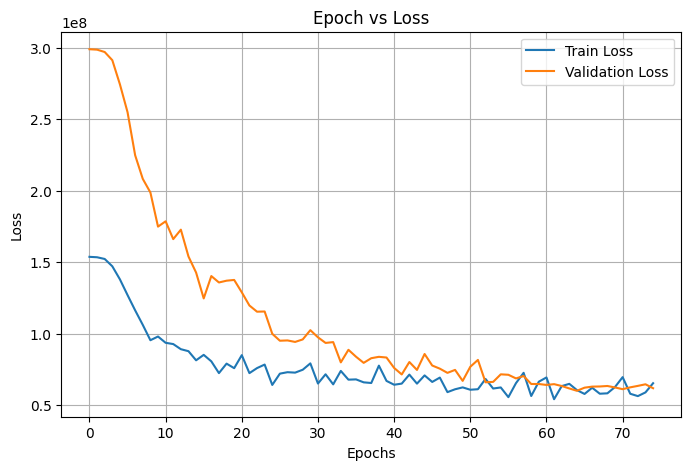

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step
CNN Model Evaluation:
MSE: 59993452.55
MAE: 2723.01
R² Score: 0.7854


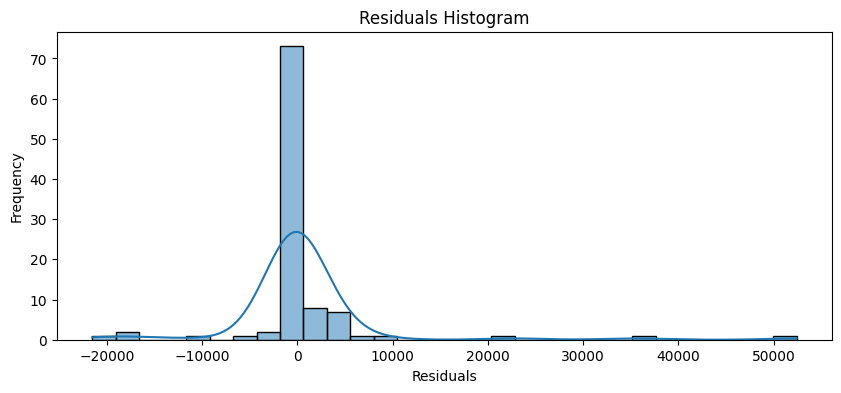

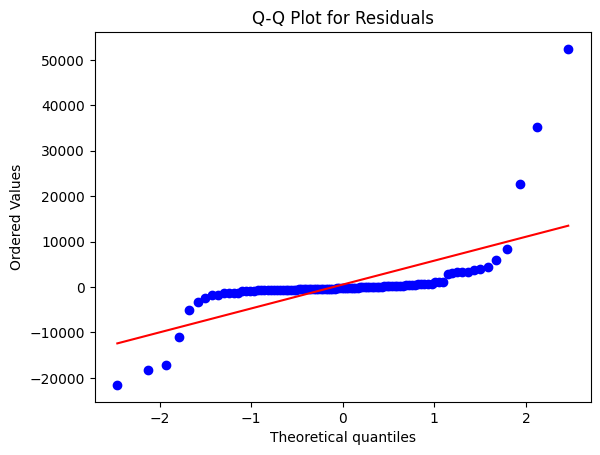

In [33]:
if __name__ == "__main__":
    main()